In [50]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_datareader as pdr
from datetime import datetime
#!pip install yfinance
import yfinance as yf
import seaborn as sns
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt

import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import adfuller


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### A pairs trading algorithm based on mean reversion is a trading strategy that involves buying and selling two highly correlated assets that tend to move together. The strategy is based on the idea that when the price of an asset deviates from its mean price, it will eventually revert back to that mean.

In [20]:
def get_historical_data(tickers):
    
    data = pd.DataFrame()
    names=list()
    for i in tickers:
        data = pd.concat([data, pd.DataFrame(yf.download(i, start=datetime(2023, 10, 22), end=datetime(2024, 10, 22)).iloc[:,4])], axis = 1)
        #data.head()
        names.append(i)
    data.columns = names
    return data

In [27]:
ticks = ["DPZ", "AAPL", "GOOG", "AMD", "GME", "SPY", "NFLX", "BA", "WMT","X","GS","XOM","NKE","META","BRK-B", "MSFT", "ASTS"] #Name of company
open_data = get_historical_data(ticks)
print(open_data.shape)
open_data.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

(251, 17)


,DPZ,AAPL,GOOG,AMD,GME,SPY,NFLX,BA,WMT,X,GS,XOM,NKE,META,BRK-B,MSFT,ASTS
Date,,,,,,,,,,,,,,,,,
2024-10-15 00:00:00+00:00,426.510010,233.610001,167.139999,163.210007,21.450001,584.590027,712.510010,150.500000,80.669998,36.209999,538.799988,120.820000,81.050003,590.159973,460.989990,422.179993,24.440001
2024-10-16 00:00:00+00:00,426.119995,231.600006,166.029999,158.070007,21.129999,579.780029,703.429993,151.910004,81.529999,37.150002,530.000000,120.889999,82.139999,581.400024,463.250000,415.170013,24.760000
2024-10-17 00:00:00+00:00,429.459991,233.429993,167.380005,160.000000,21.500000,585.909973,704.349976,155.000000,81.269997,38.099998,531.239990,120.760002,84.110001,583.330017,466.100006,422.359985,27.840000
2024-10-18 00:00:00+00:00,430.989990,236.179993,164.869995,157.410004,21.410000,584.070007,737.640015,155.839996,80.870003,37.980000,529.390015,120.440002,83.779999,581.099976,467.000000,417.140015,28.790001
2024-10-21 00:00:00+00:00,429.000000,234.449997,164.580002,155.759995,21.100000,583.849976,765.760010,160.250000,81.230003,37.849998,528.000000,120.980003,82.849998,576.030029,464.529999,416.119995,28.520000


In [28]:
corr_matrix = open_data.corr()
corr_matrix

,DPZ,AAPL,GOOG,AMD,GME,SPY,NFLX,BA,WMT,X,GS,XOM,NKE,META,BRK-B,MSFT,ASTS
DPZ,1.000000,-0.040836,0.698296,0.563698,0.319986,0.485852,0.518198,-0.316028,0.199574,0.040011,0.426770,0.482035,-0.302724,0.509931,0.322304,0.690987,-0.145944
AAPL,-0.040836,1.000000,0.585844,-0.003474,0.611509,0.711936,0.631628,-0.376336,0.788073,-0.270718,0.769566,0.333801,-0.637131,0.500612,0.651716,0.492605,0.857573
GOOG,0.698296,0.585844,1.000000,0.344326,0.644458,0.797365,0.769434,-0.571898,0.663020,-0.244475,0.819643,0.677722,-0.751505,0.676540,0.647390,0.835819,0.409651
AMD,0.563698,-0.003474,0.344326,1.000000,0.087848,0.535475,0.569437,-0.186142,0.238229,0.473558,0.346907,0.186522,-0.201046,0.632462,0.434790,0.680591,-0.058621
GME,0.319986,0.611509,0.644458,0.087848,1.000000,0.557966,0.519330,-0.290516,0.532435,-0.222837,0.624931,0.336563,-0.485328,0.384609,0.446620,0.476102,0.446639
SPY,0.485852,0.711936,0.797365,0.535475,0.557966,1.000000,0.977486,-0.670736,0.904286,-0.125059,0.956022,0.704832,-0.786787,0.933768,0.942374,0.867028,0.698870
NFLX,0.518198,0.631628,0.769434,0.569437,0.519330,0.977486,1.000000,-0.717630,0.887918,-0.144790,0.905348,0.721202,-0.760165,0.958058,0.933300,0.878300,0.652177
BA,-0.316028,-0.376336,-0.571898,-0.186142,-0.290516,-0.670736,-0.717630,1.000000,-0.791806,0.511453,-0.647940,-0.800374,0.752418,-0.739390,-0.741528,-0.532037,-0.537259
WMT,0.199574,0.788073,0.663020,0.238229,0.532435,0.904286,0.887918,-0.791806,1.000000,-0.377694,0.899131,0.707524,-0.811299,0.834900,0.919420,0.654251,0.865776
X,0.040011,-0.270718,-0.244475,0.473558,-0.222837,-0.125059,-0.144790,0.511453,-0.377694,1.000000,-0.173579,-0.430474,0.284745,-0.069880,-0.188584,-0.007700,-0.322184


<Axes: >

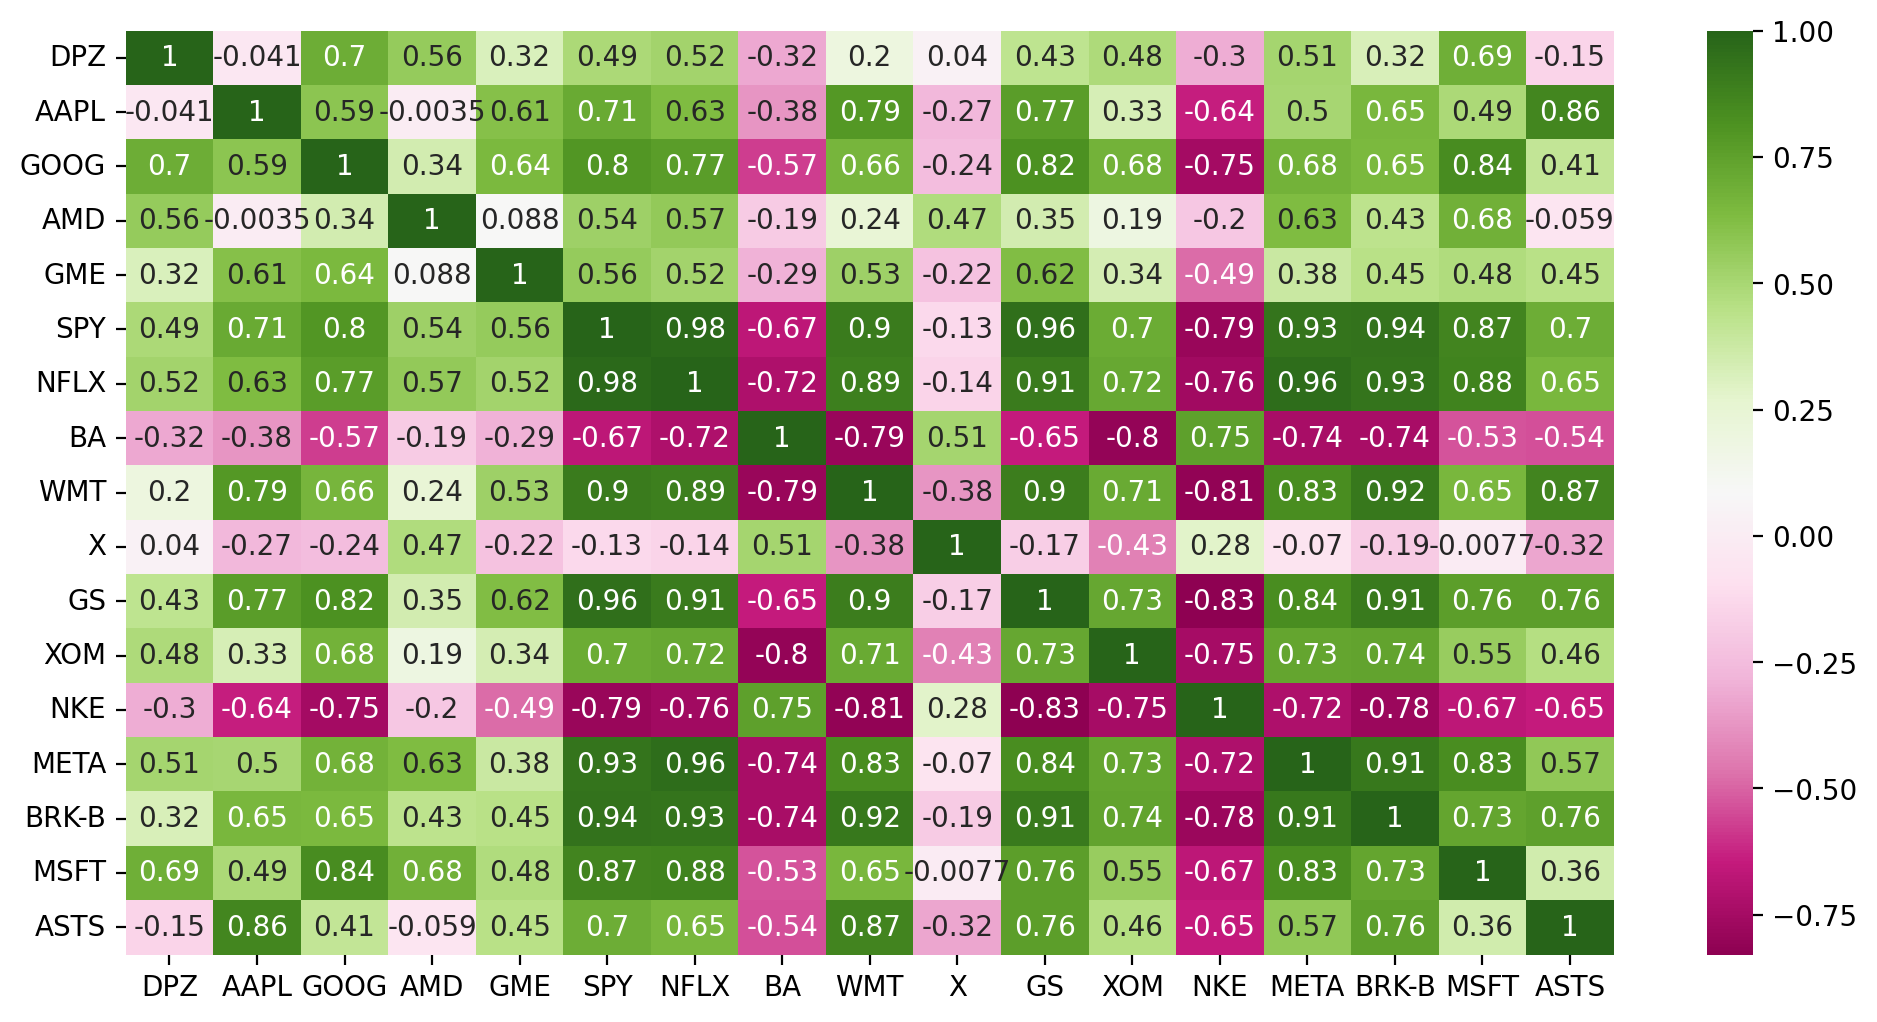

In [37]:
figure(figsize=(12, 6), dpi=200)
sns.heatmap(corr_matrix, annot = True, cmap="PiYG")


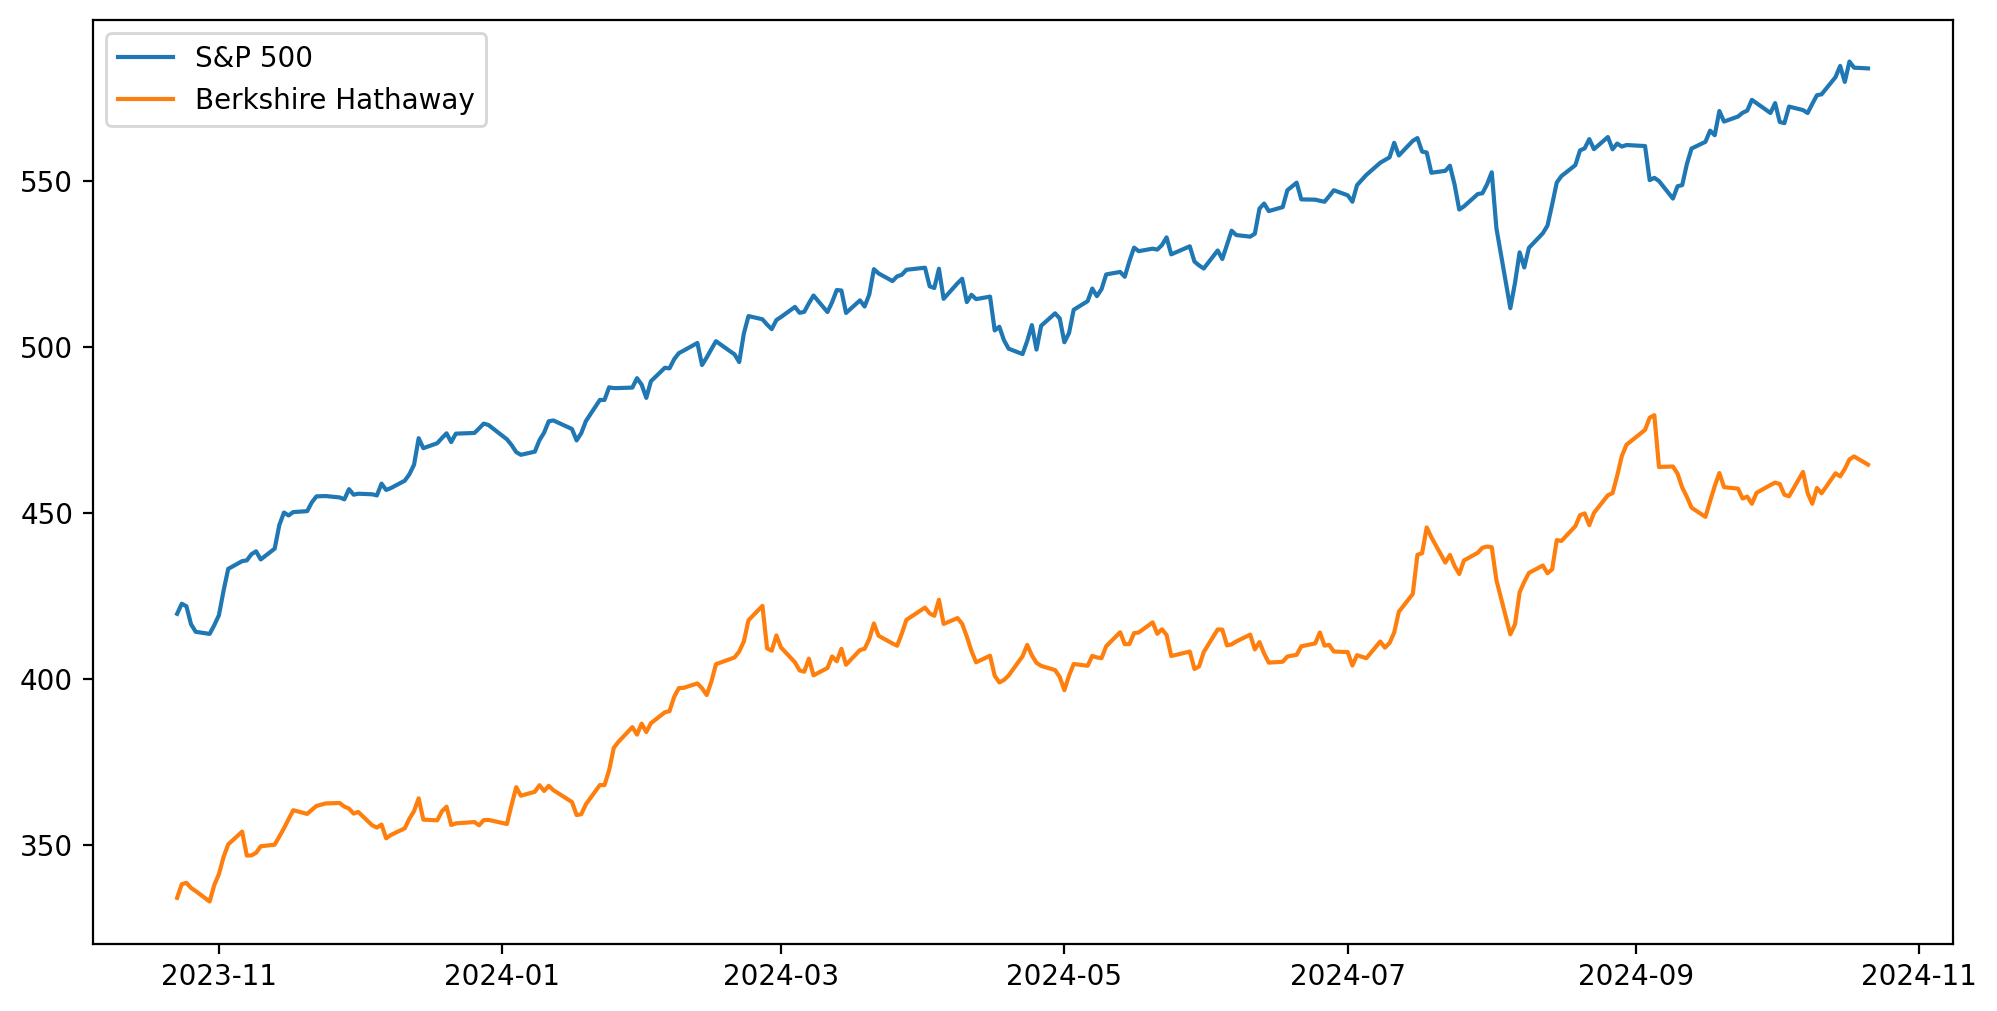

In [43]:
figure(figsize=(12, 6), dpi=200)
SPY = open_data['SPY']
BRK_B = open_data['BRK-B']

plt.plot(SPY, label="S&P 500")
plt.plot(BRK_B, label="Berkshire Hathaway")
plt.legend()

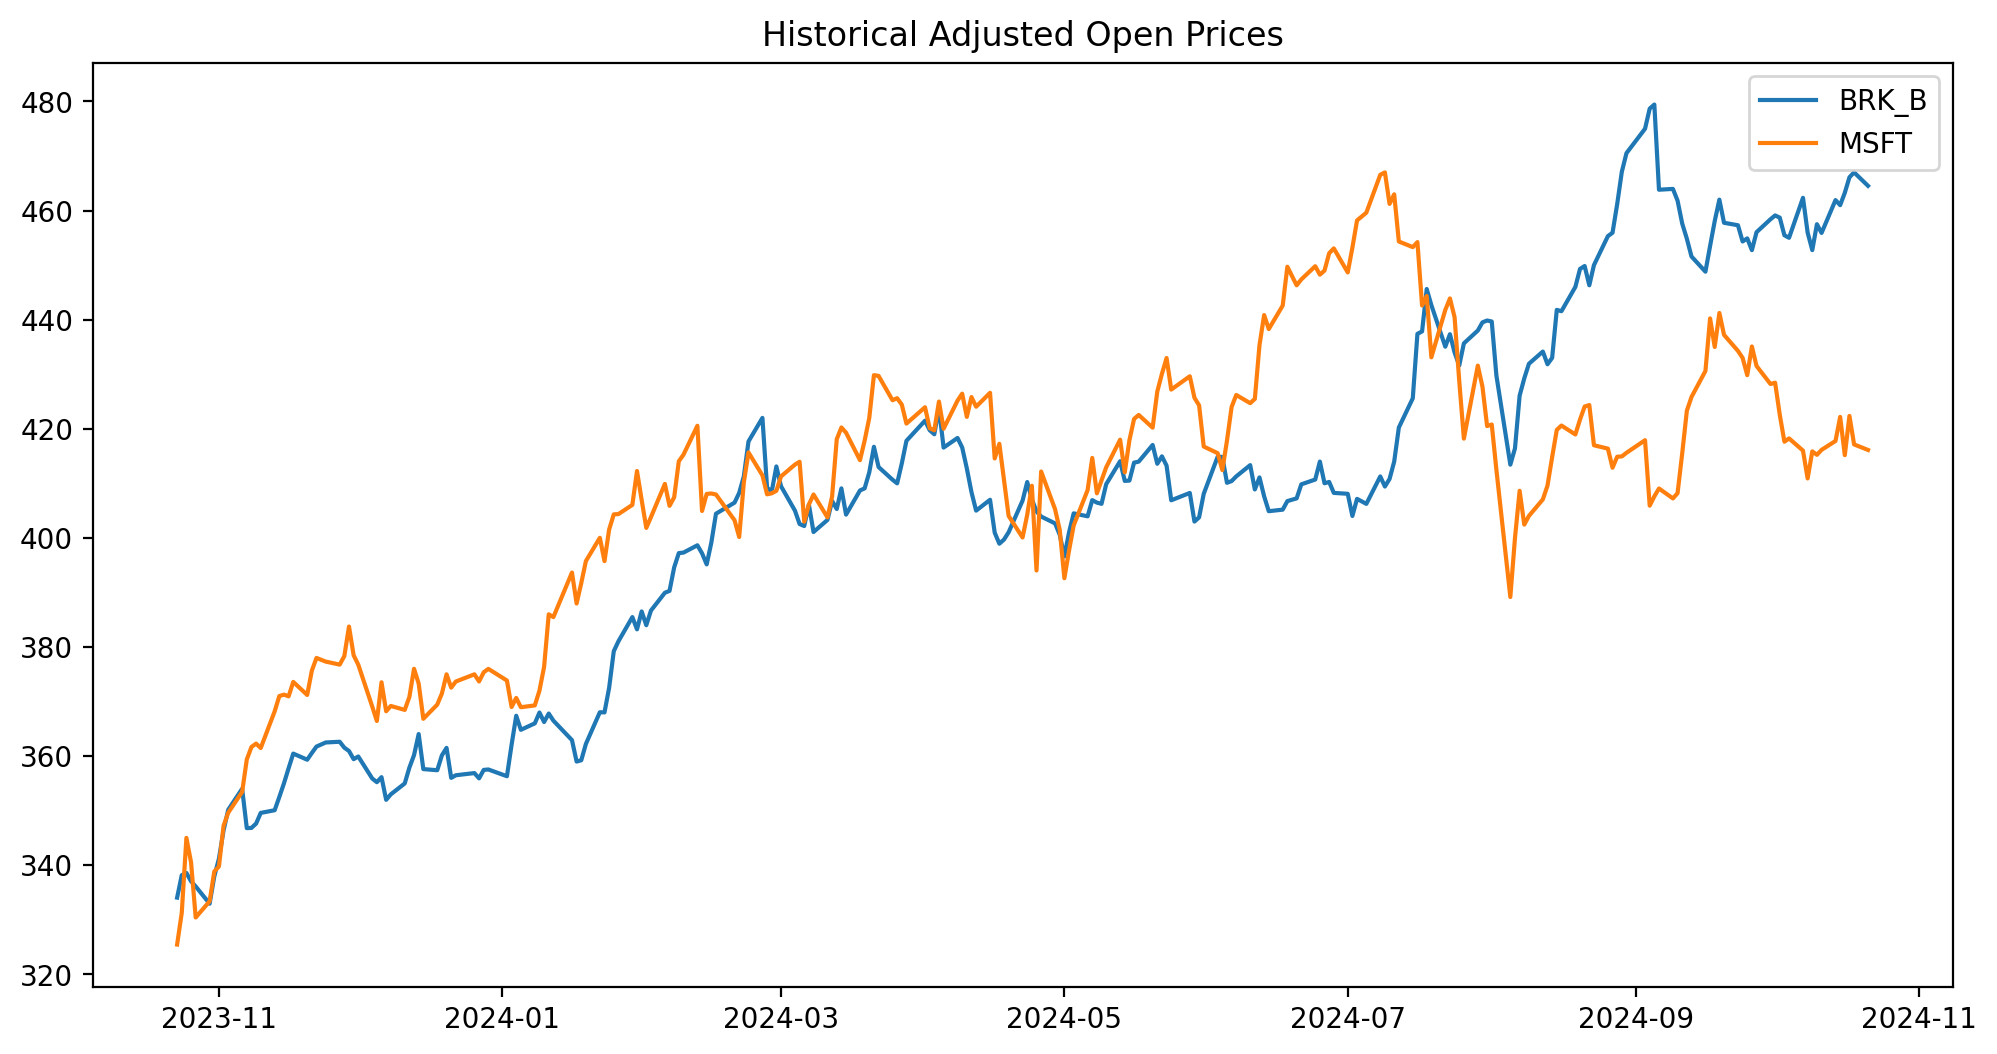

In [45]:
figure(figsize=(12, 6), dpi=200)
BRK_B = open_data['BRK-B']
MSFT = open_data['MSFT']
plt.plot(BRK_B, label = "BRK_B")
plt.plot(MSFT, label = "MSFT")
plt.title('Historical Adjusted Open Prices')
plt.legend()

Text(0.5, 1.0, 'Spread between BRK-B and MSFT')

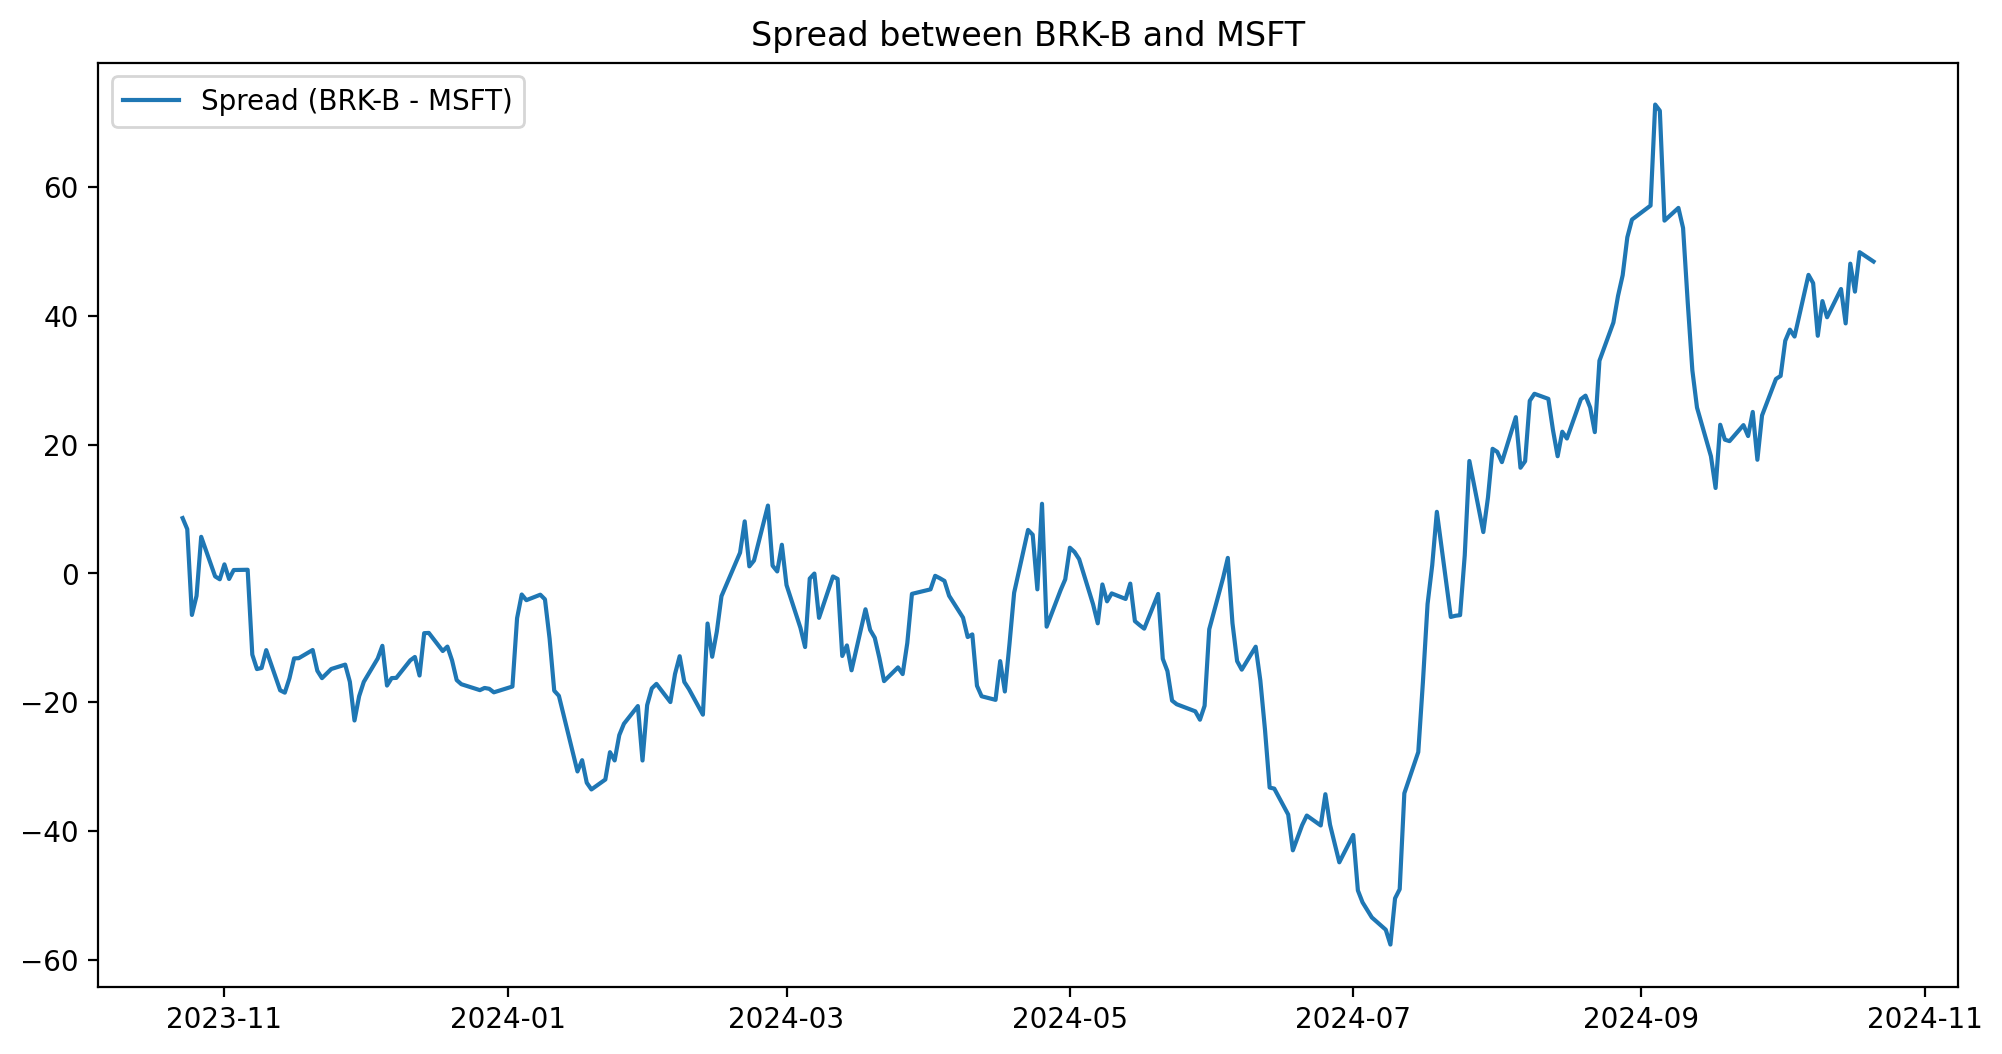

In [54]:
# plot the spread
figure(figsize=(12, 6), dpi=200)
plt.plot(BRK_B - MSFT, label = 'Spread (BRK-B - MSFT)')
plt.legend()
plt.title("Spread between BRK-B and MSFT")

In [49]:
result = ts.coint(BRK_B, MSFT)
print(result)
#Cointegration test: A technique used to find a potential correlation in a time series (long term)
# Determines if the spread between the two assets are constant over time.
# Null Hypothesis: Spread between series are non-stationary.
# Uses the augmented Engle-Granger two-step cointegration test.
cointegration_t_statistic = result[0]
p_val = result[1]
critical_values_test_statistic_at_1_5_10 = result[2]
print('We want the P val < 0.05 (meaning that cointegration exists)')
print('P value for the augmented Engle-Granger two-step cointegration test is', p_val)

(-1.2335547483337996, 0.8488941061397637, array([-3.94078403, -3.36067957, -3.06145832]))
We want the P val < 0.05 (meaning that cointegration exists)
P value for the augmented Engle-Granger two-step cointegration test is 0.8488941061397637


In [52]:
# Compute the ADF test for Berkshire Hathaway and Microsoft
# With all time series, you want to have stationary data otherwise our data will be very hard to predict.
# ADF for Berkshire Hathaway Class B
BRK_B_ADF = adfuller(BRK_B)
print('P value for the BRK_B Augmented Dickey-Fuller Test is', BRK_B_ADF[1])
MSFT_ADF = adfuller(MSFT)
print('P value for the MSFT Augmented Dickey-Fuller Test is', MSFT_ADF[1])
Spread_ADF = adfuller(BRK_B - MSFT)
print('P value for the Spread Augmented Dickey-Fuller Test is', Spread_ADF[1])
Ratio_ADF = adfuller(BRK_B / MSFT)
print('P value for the Ratio Augmented Dickey-Fuller Test is', Ratio_ADF[1])
# Spread looks fine. If you'd want even better results, consider taking the difference (order 1) of Berkshire and MSFT

# Results: can only claim stationary for the spread (since P value < 0.05). This suggests a constant mean over time.
# Therefore, the two series are cointegrated.

P value for the BRK_B Augmented Dickey-Fuller Test is 0.6770955505602131
P value for the MSFT Augmented Dickey-Fuller Test is 0.04828874495586436
P value for the Spread Augmented Dickey-Fuller Test is 0.6138783776765472
P value for the Ratio Augmented Dickey-Fuller Test is 0.5793943480869564


Text(0.5, 1.0, 'Price Ratio between BRK and MSFT')

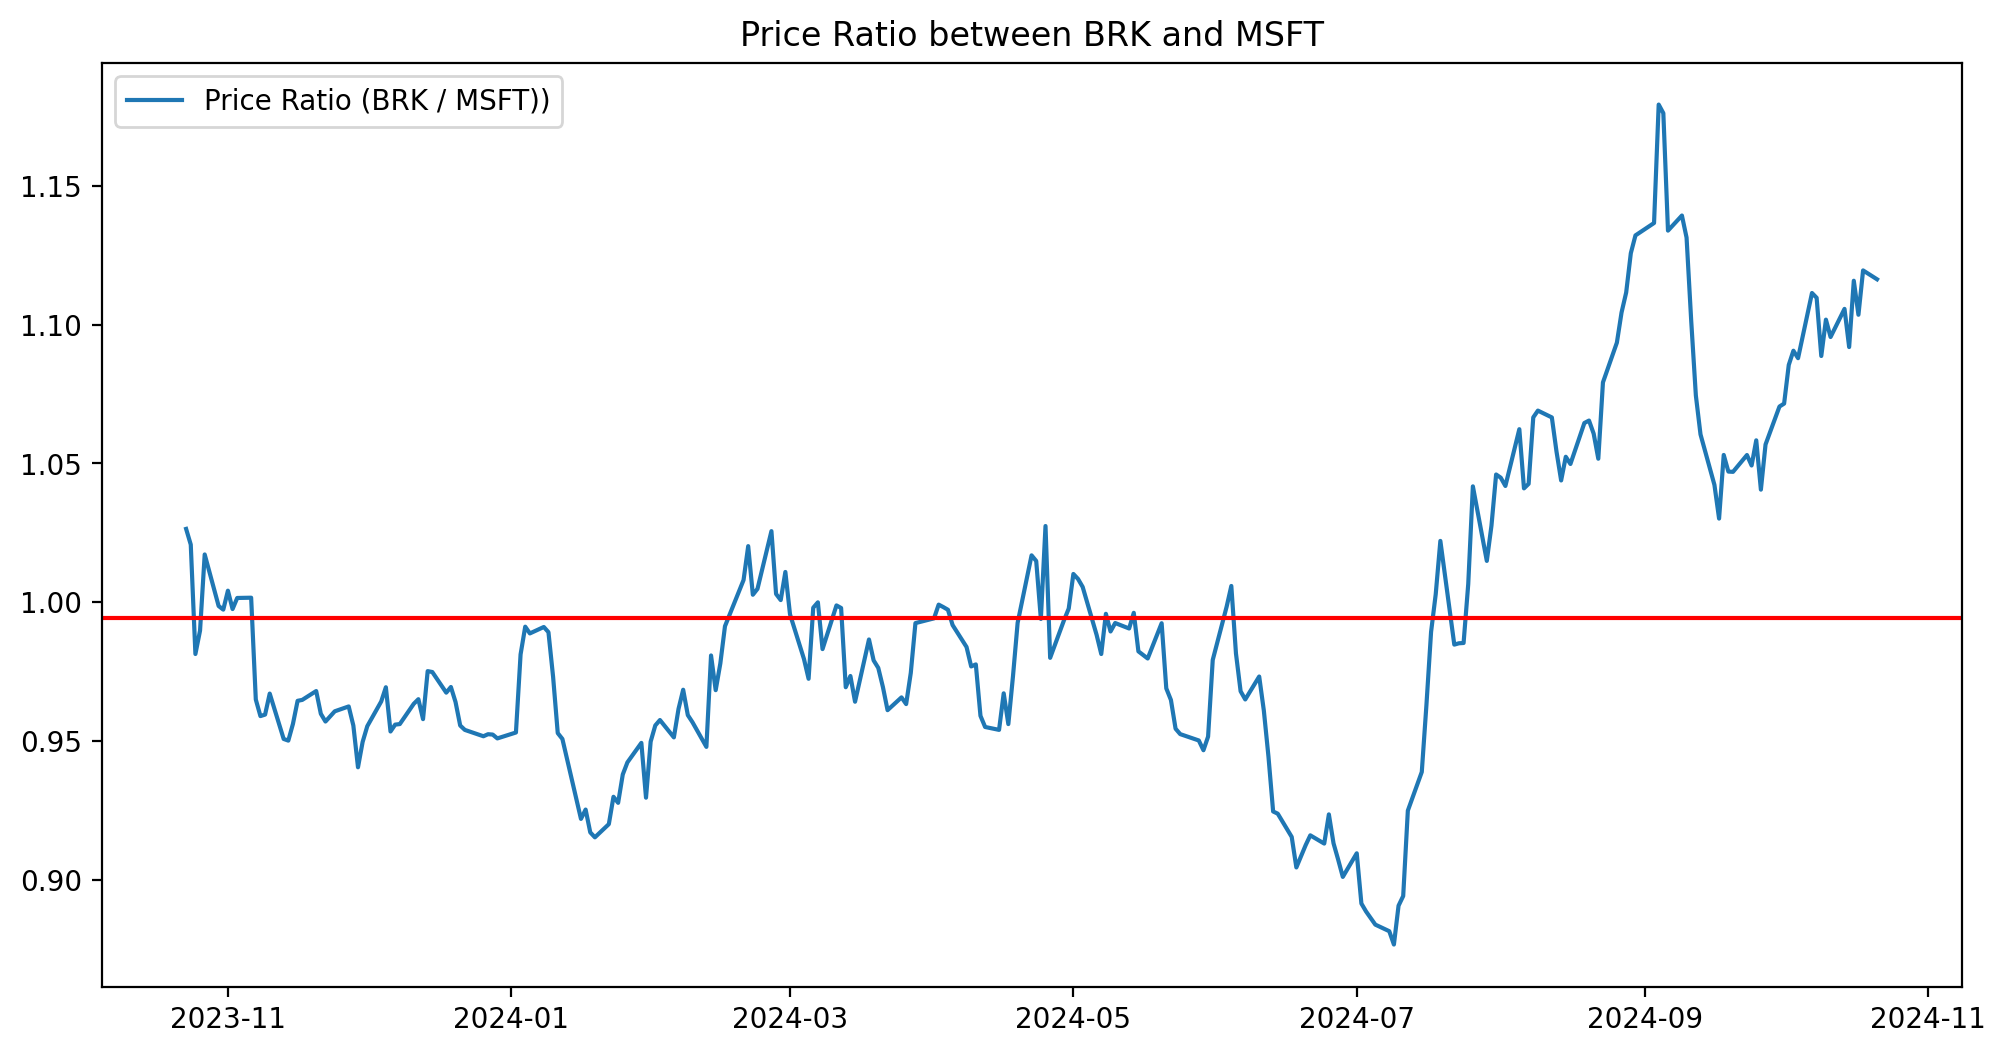

In [55]:
figure(figsize=(12, 6), dpi=200)
ratio = BRK_B / MSFT
plt.plot(ratio, label = 'Price Ratio (BRK / MSFT))')
plt.axhline(ratio.mean(), color='red')
plt.legend()
plt.title("Price Ratio between BRK and MSFT")

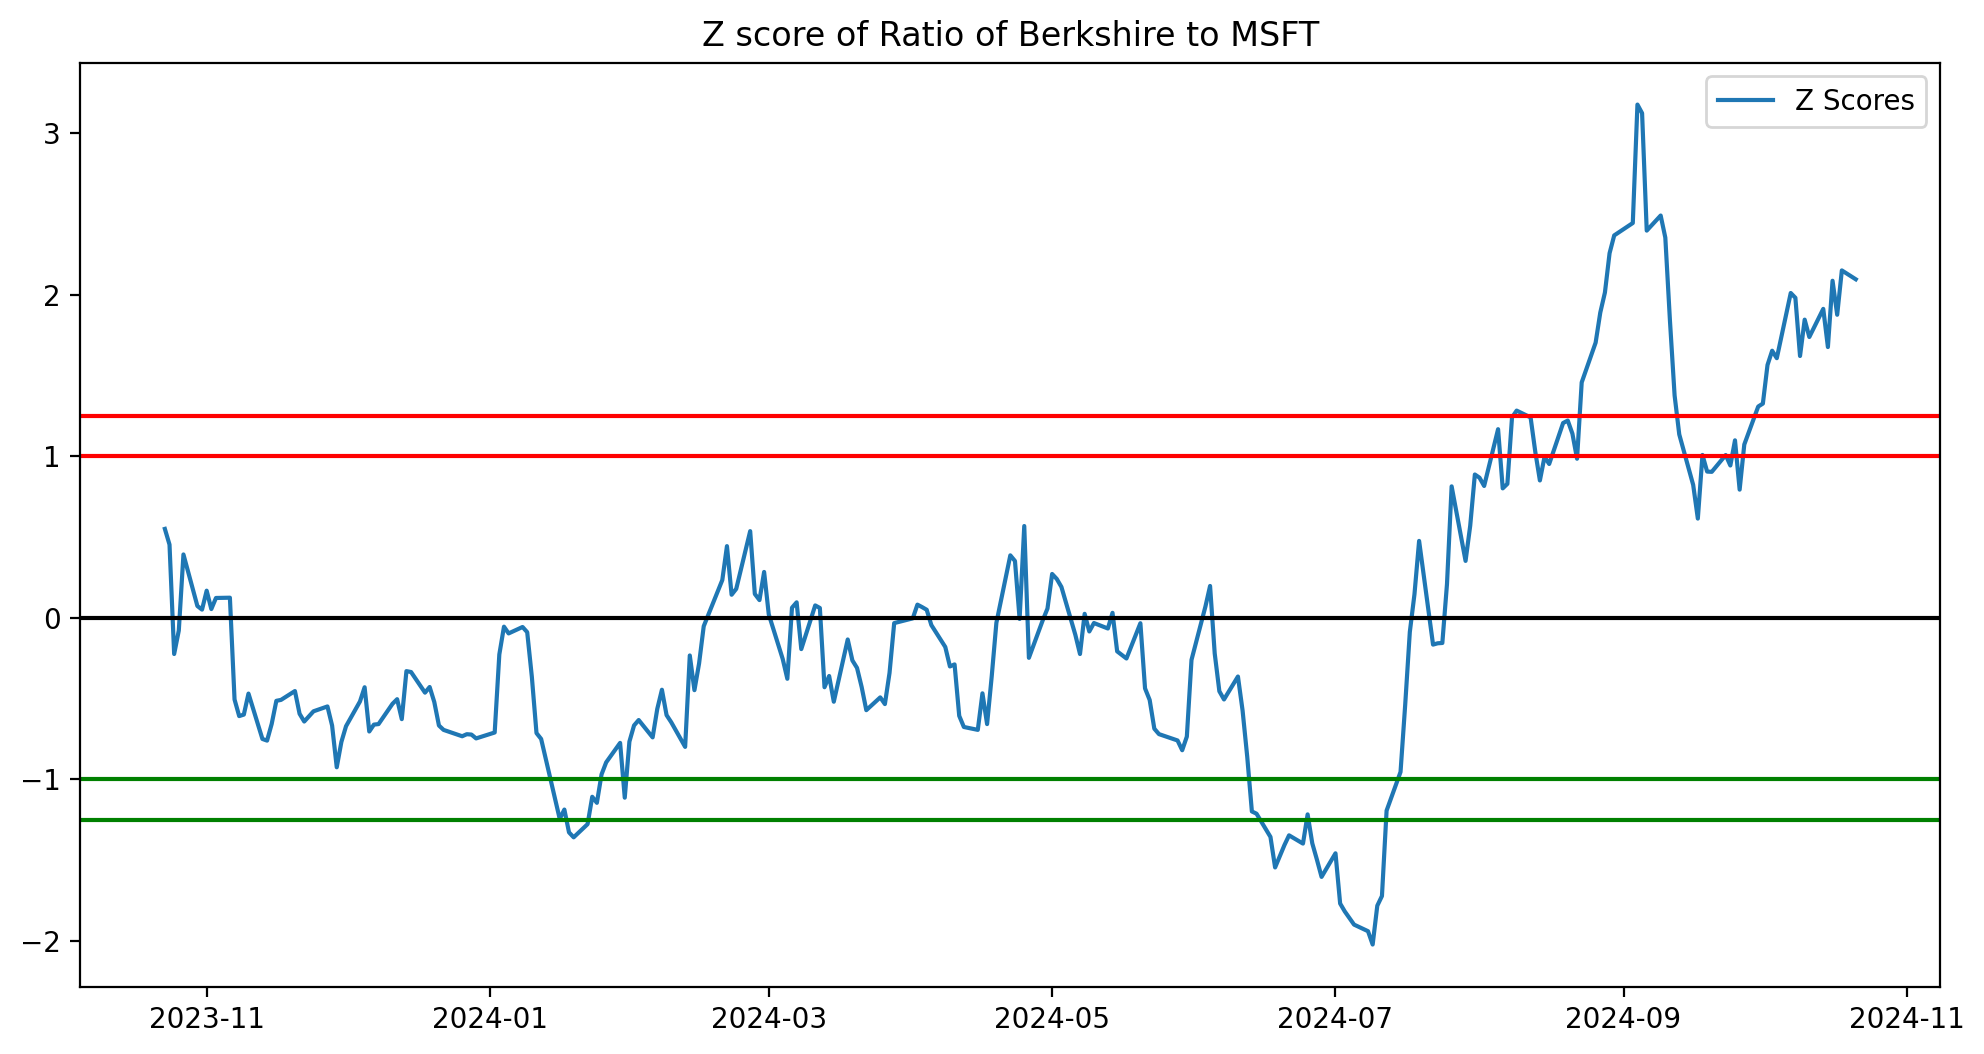

In [57]:
# NOTE, here you can either use the spread OR the Price ratio approach. Anyways, let's standardize the ratio so we can have a 
# upper and lower bound to help evaluate our trends.. Let's stick with the ratio data.
figure(figsize=(12, 6), dpi=200)
# Calculate the Zscores of each row.
df_zscore = (ratio - ratio.mean())/ratio.std()
plt.plot(df_zscore, label = "Z Scores")
plt.axhline(df_zscore.mean(), color = 'black')
plt.axhline(1.0, color='red') # Setting the upper and lower bounds to be the z score of 1 and -1 (1/-1 standard deviation)
plt.axhline(1.25, color='red') # 95% of our data will lie between these bounds.
plt.axhline(-1.0, color='green') # 68% of our data will lie between these bounds.
plt.axhline(-1.25, color='green') # 95% of our data will lie between these bounds.
plt.legend(loc = 'best')
plt.title('Z score of Ratio of Berkshire to MSFT')
plt.show()
# For the most part, the range that exists outside of these 'bands' must come converge back to the mean. Thus, you can 
# determine when you can go long or short the pair (BRK_B to MSFT).

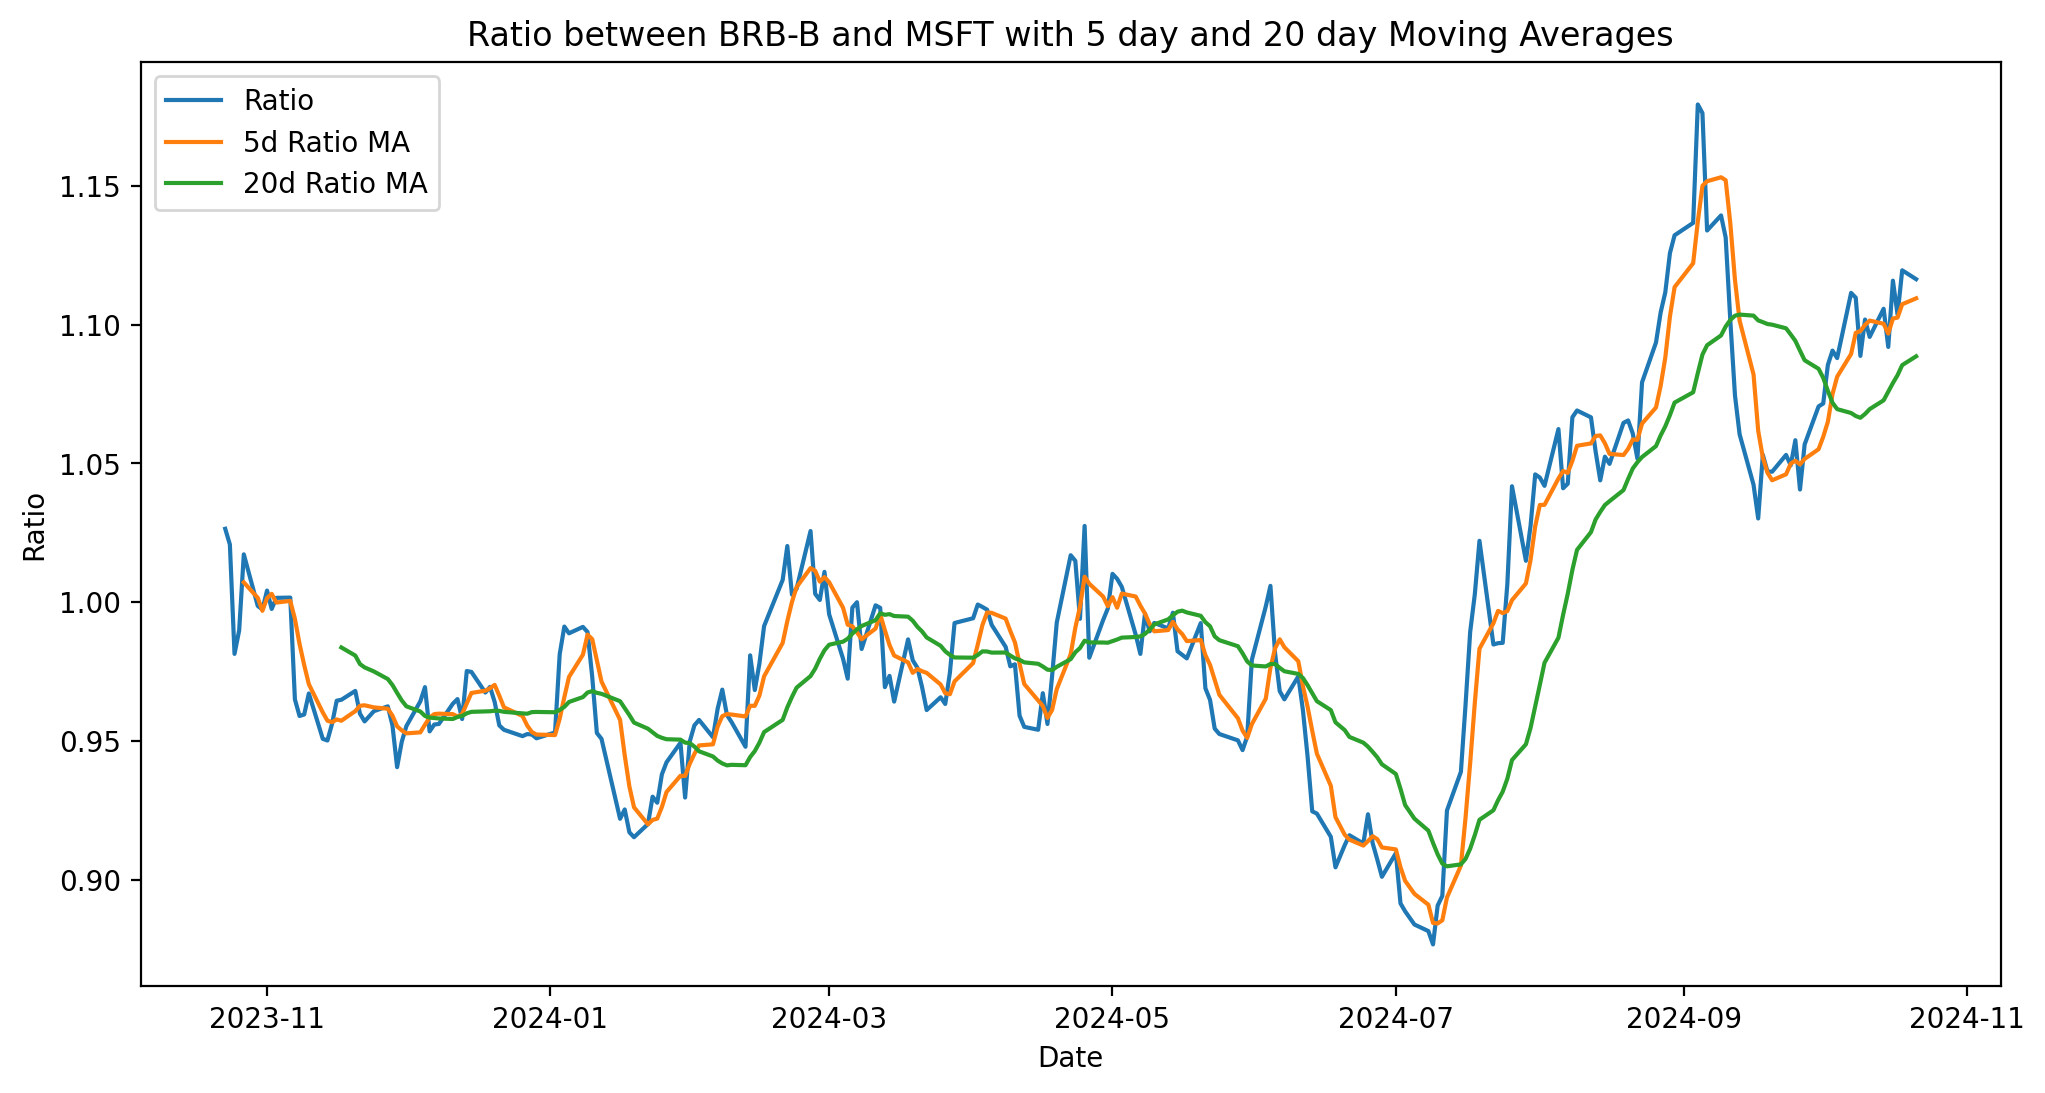

In [58]:
figure(figsize=(12, 6), dpi=200)
ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
ratios_mavg20 = ratio.rolling(window=20, center=False).mean()
std_20 = ratio.rolling(window=20, center=False).std()
zscore_20_5 = (ratios_mavg5 - ratios_mavg20)/std_20
plt.plot(ratio.index, ratio.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg20.index, ratios_mavg20.values)
plt.legend(['Ratio', '5d Ratio MA', '20d Ratio MA'])
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Ratio between BRB-B and MSFT with 5 day and 20 day Moving Averages')
plt.show()

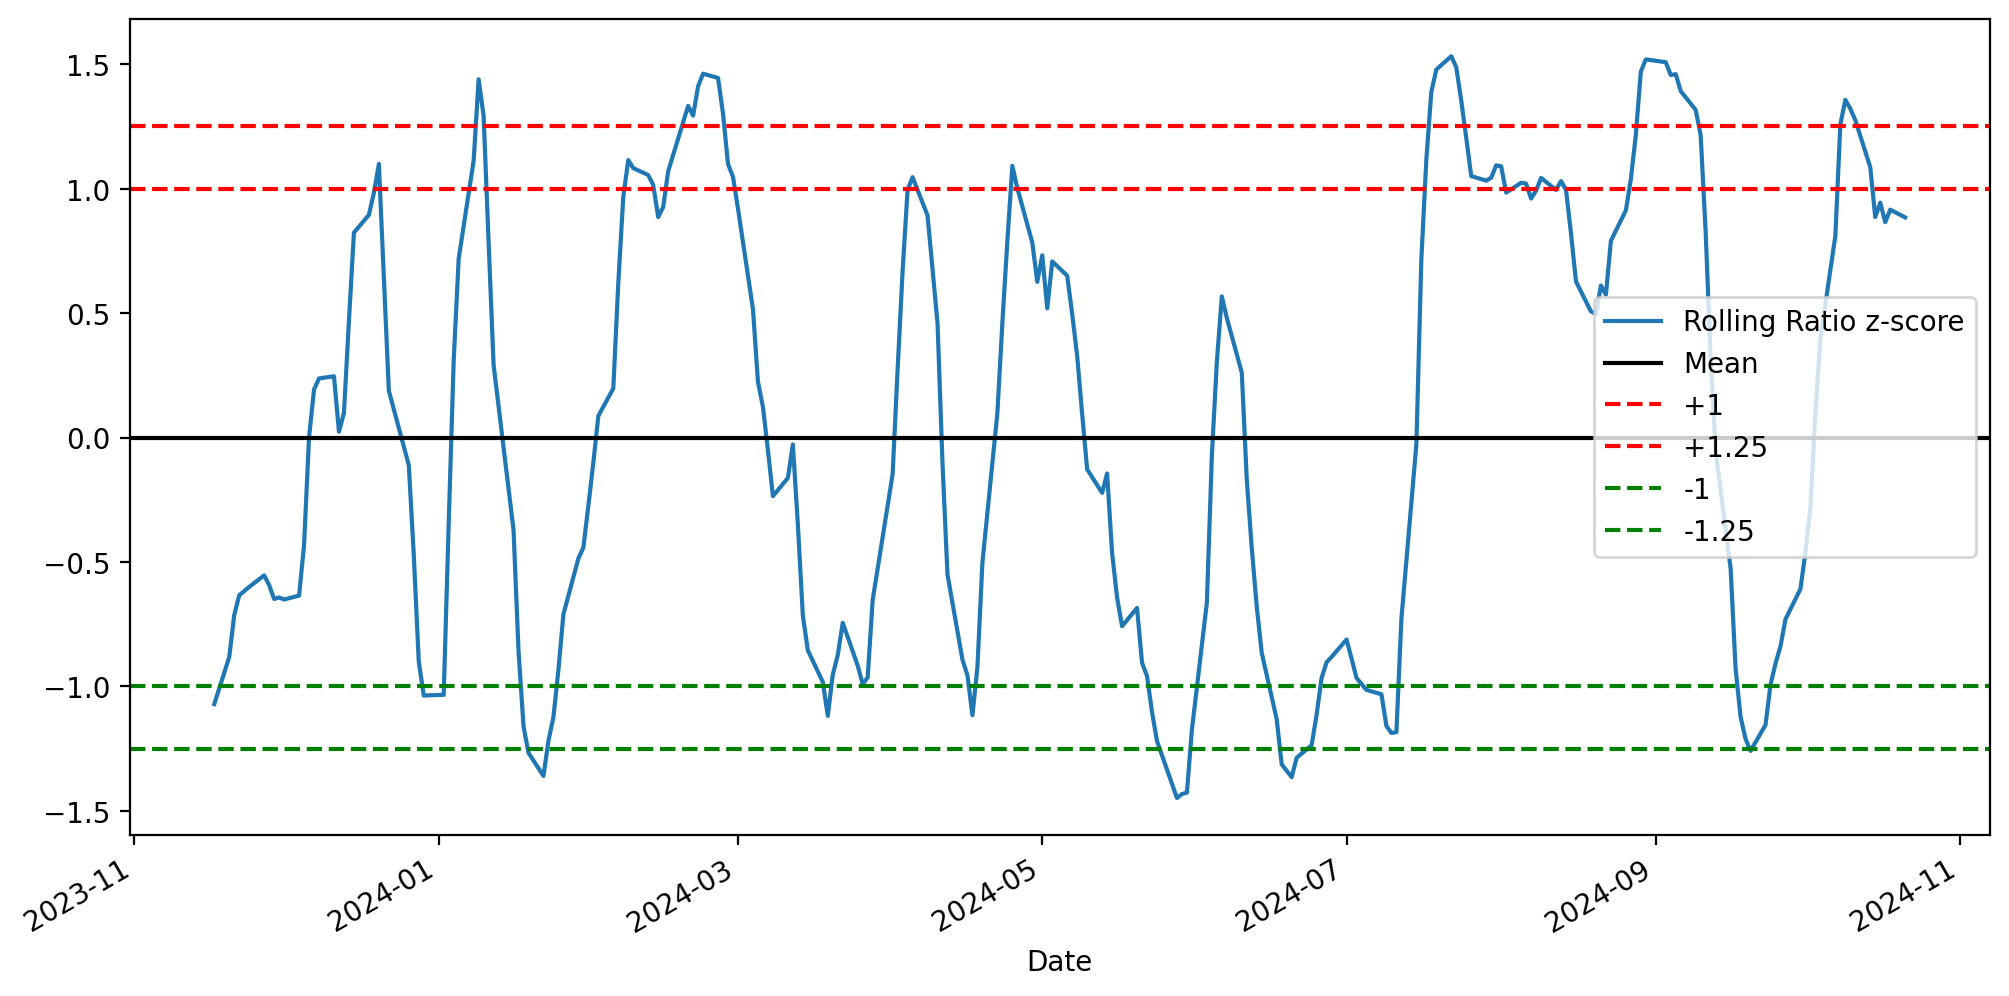

In [59]:
figure(figsize=(12, 6), dpi=200)
zscore_20_5.plot()
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(1.25, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(-1.25, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-score', 'Mean', '+1','+1.25','-1','-1.25'])
plt.show()

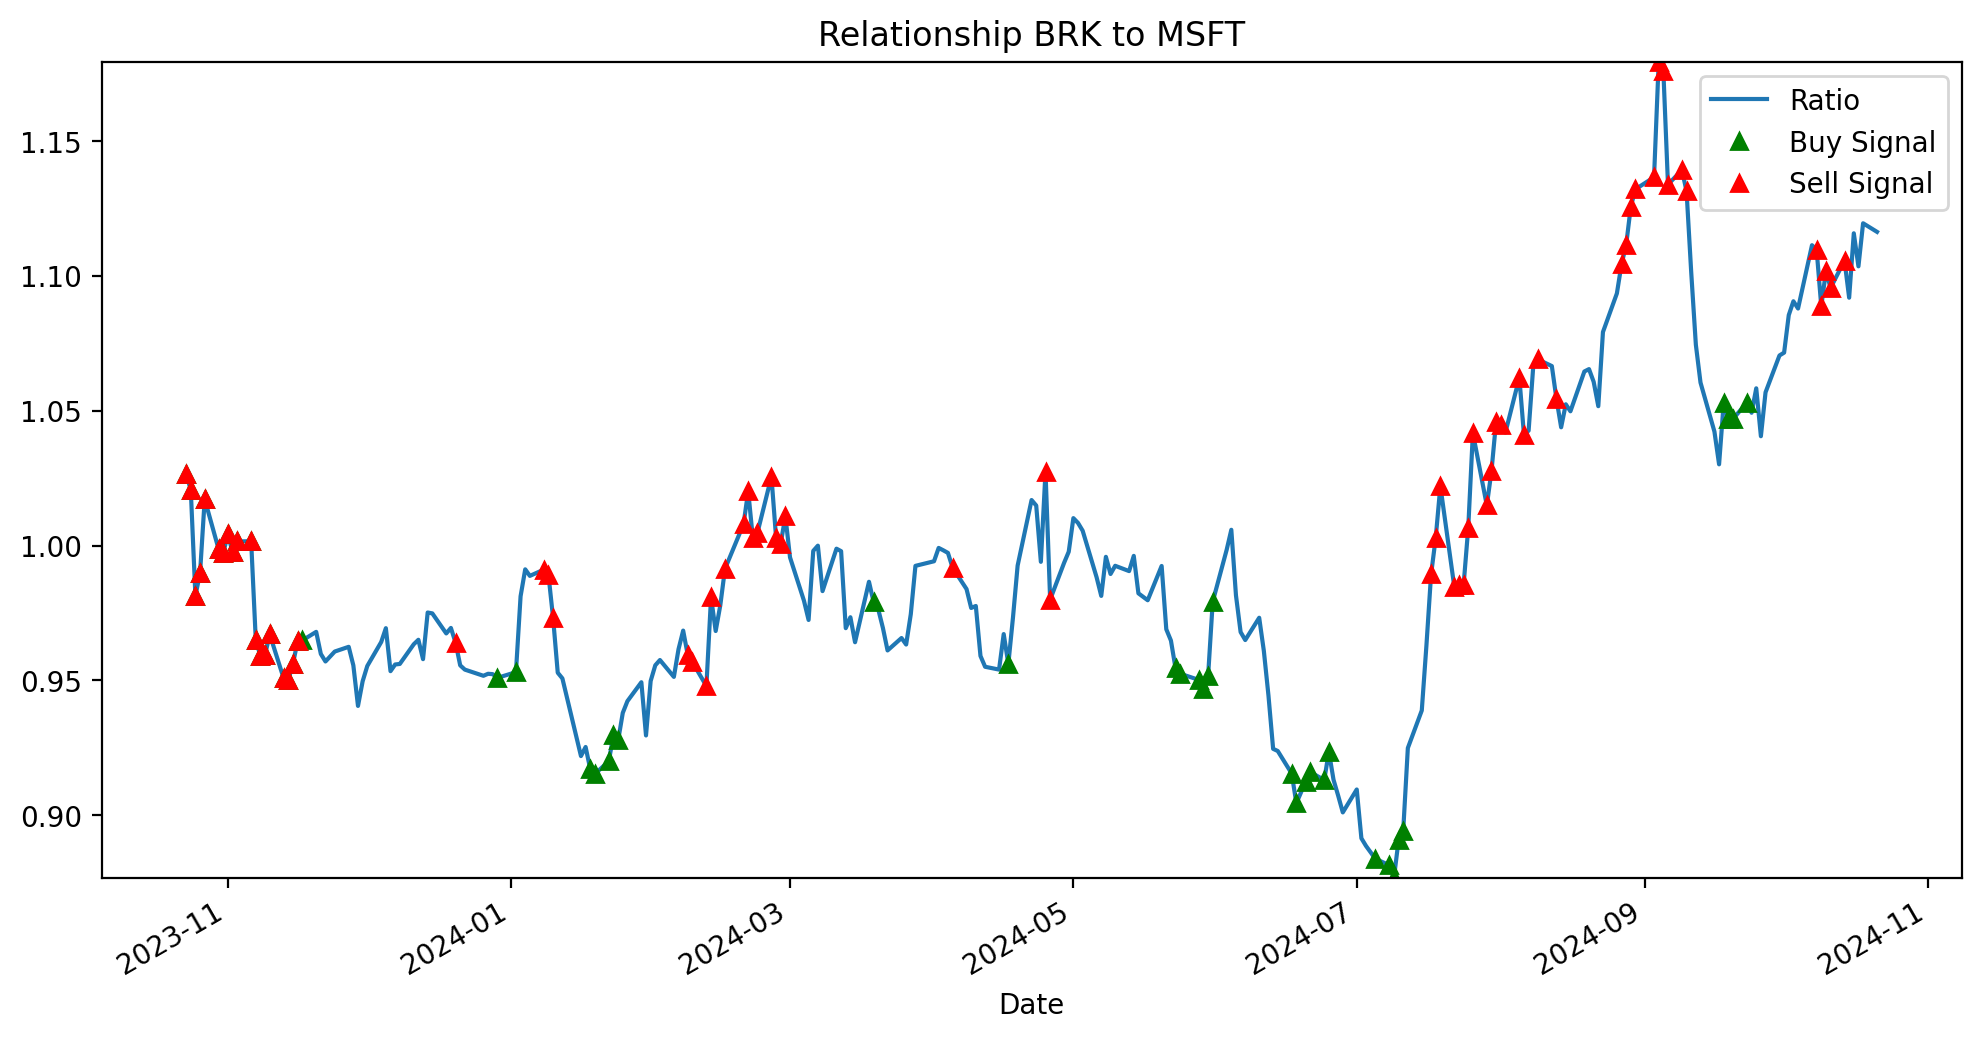

In [61]:
figure(figsize=(12, 6), dpi=200)
ratio.plot()
buy = ratio.copy()
sell = ratio.copy()
buy[zscore_20_5>-1] = 0
sell[zscore_20_5<1] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship BRK to MSFT')
plt.show()